This notebook assumes an installation of the SageMaker kernel `conda_pytorch_p310`. In addition, libraries from a requirements.txt need to be installed:

In [1]:
!pip install --no-deps -U -q -r ../../requirements.txt

In [2]:
%%capture

# Reshaping/basic libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

# Operational libraries
import sys

sys.path.append("..")
sys.path.insert(1, "..")

# Fairness libraries
from folktables.acs import *
from folktables.folktables import *
from folktables.load_acs import *
from fairlearn.reductions import EqualizedOdds
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import MetricFrame, selection_rate

# Jupyter(lab) libraries
import warnings

warnings.filterwarnings("ignore")

## 1. <a name="1">Read the datasets</a> (Given)
(<a href="#0">Go to top</a>)

Then, we read the __training__ and __test__ datasets into dataframes, using [Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html). This library allows us to read and manipulate our data.

In [3]:
training_data = pd.read_csv("../../data/final_project/german_credit_training.csv")
test_data = pd.read_csv("../../data/final_project/german_credit_test.csv")

print("The shape of the training dataset is:", training_data.shape)
print("The shape of the test dataset is:", test_data.shape)

The shape of the training dataset is: (800, 24)
The shape of the test dataset is: (200, 23)


## 2. <a name="2">Data Processing</a> (Implement)
(<a href="#0">Go to top</a>) 

### 2.1 <a name="21">Exploratory Data Analysis</a>
(<a href="#2">Go to Data Processing</a>)

We look at number of rows, columns, and some simple statistics of the datasets.

In [4]:
training_data.head()

,ID,sex,personal_status,checking_account_status,credit_duration_months,credit_history,credit_purpose,credit_amount,savings,employed_since_years,...,age_years,other_installment_plans,housing,num_existing_credits,job_status,num_people_liable_for,telephone,foreign_worker,credit_risk,age_groups
0,564,male,married/widowed,... < 0 DM,24,existing credits paid back duly till now,retraining,4712,.. >= 1000 DM,1 <= ... < 4 years,...,37,bank,rent,2-3,management/self-employed/highly qualified empl...,0 to 2,True,False,0,1
1,484,male,married/widowed,... >= 200 DM,12,all credits at this bank paid back duly,others,1163,100 <= ... < 500 DM,1 <= ... < 4 years,...,44,none,rent,1,skilled employee/official,0 to 2,True,False,0,1
2,26,female,single,... >= 200 DM,6,delay in paying off in the past,furniture/equipment,426,unknown/no savings account,.. >= 7 years,...,39,none,rent,1,unskilled - resident,0 to 2,False,False,0,1
3,443,male,married/widowed,... >= 200 DM,12,no credits taken/all credits paid back duly,repairs,719,unknown/no savings account,.. >= 7 years,...,41,bank,rent,1,unskilled - resident,3 or more,False,False,1,1
4,211,female/male,female (non-single) or male (single),... >= 200 DM,36,no credits taken/all credits paid back duly,furniture/equipment,3835,.. >= 1000 DM,.. >= 7 years,...,45,none,rent,1,unskilled - resident,0 to 2,True,False,0,1


In [5]:
test_data.head()

,ID,sex,personal_status,checking_account_status,credit_duration_months,credit_history,credit_purpose,credit_amount,savings,employed_since_years,...,property,age_years,other_installment_plans,housing,num_existing_credits,job_status,num_people_liable_for,telephone,foreign_worker,age_groups
0,963,male,married/widowed,... >= 200 DM,24,no credits taken/all credits paid back duly,furniture/equipment,2397,100 <= ... < 500 DM,.. >= 7 years,...,building society savings agreement/life insurance,35,bank,rent,2-3,skilled employee/official,0 to 2,True,False,1
1,611,female/male,female (non-single) or male (single),0 <= ... < 200 DM,10,no credits taken/all credits paid back duly,others,1240,... < 100 DM,.. >= 7 years,...,real estate,48,none,own,1,unskilled - resident,3 or more,False,False,1
2,106,male,married/widowed,... >= 200 DM,18,critical account/other credits existing (not a...,others,6458,unknown/no savings account,.. >= 7 years,...,real estate,39,bank,rent,2-3,management/self-employed/highly qualified empl...,3 or more,True,False,1
3,891,male,married/widowed,... >= 200 DM,15,all credits at this bank paid back duly,furniture/equipment,1829,unknown/no savings account,.. >= 7 years,...,building society savings agreement/life insurance,46,none,rent,2-3,skilled employee/official,0 to 2,True,False,1
4,342,female,single,... < 0 DM,18,no credits taken/all credits paid back duly,furniture/equipment,3213,100 <= ... < 500 DM,... < 1 year,...,unknown/no property,25,none,for free,1,skilled employee/official,0 to 2,False,False,1


In [6]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID                        800 non-null    int64 
 1   sex                       800 non-null    object
 2   personal_status           800 non-null    object
 3   checking_account_status   800 non-null    object
 4   credit_duration_months    800 non-null    int64 
 5   credit_history            800 non-null    object
 6   credit_purpose            800 non-null    object
 7   credit_amount             800 non-null    int64 
 8   savings                   800 non-null    object
 9   employed_since_years      800 non-null    object
 10  installment_rate          800 non-null    object
 11  other_debtors_guarantors  800 non-null    object
 12  present_residence_since   800 non-null    object
 13  property                  800 non-null    object
 14  age_years                 

In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID                        200 non-null    int64 
 1   sex                       200 non-null    object
 2   personal_status           200 non-null    object
 3   checking_account_status   200 non-null    object
 4   credit_duration_months    200 non-null    int64 
 5   credit_history            200 non-null    object
 6   credit_purpose            200 non-null    object
 7   credit_amount             200 non-null    int64 
 8   savings                   200 non-null    object
 9   employed_since_years      200 non-null    object
 10  installment_rate          200 non-null    object
 11  other_debtors_guarantors  200 non-null    object
 12  present_residence_since   200 non-null    object
 13  property                  200 non-null    object
 14  age_years                 

In [8]:
training_data.describe()

,ID,credit_duration_months,credit_amount,age_years,credit_risk,age_groups
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,498.328750,20.952500,3255.261250,35.358750,0.300000,0.851250
std,289.320919,12.209487,2853.047392,11.259819,0.458544,0.356064
min,0.000000,4.000000,250.000000,19.000000,0.000000,0.000000
25%,248.750000,12.000000,1359.500000,27.000000,0.000000,1.000000
50%,495.500000,18.000000,2278.500000,33.000000,0.000000,1.000000
75%,748.500000,24.000000,3951.500000,42.000000,1.000000,1.000000
max,999.000000,72.000000,15945.000000,75.000000,1.000000,1.000000


In [9]:
training_data["credit_risk"].value_counts()

0    560
1    240
Name: credit_risk, dtype: int64

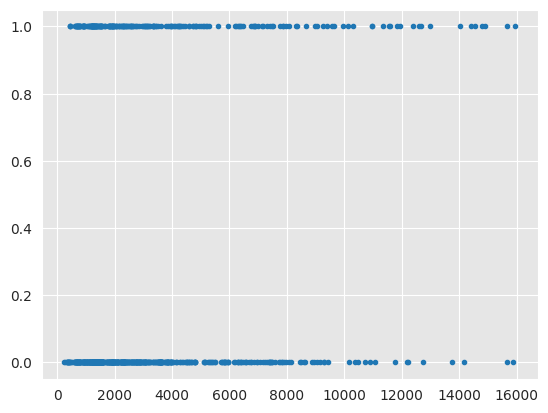

In [11]:
plt.plot(training_data["credit_amount"], training_data["credit_risk"], ".")

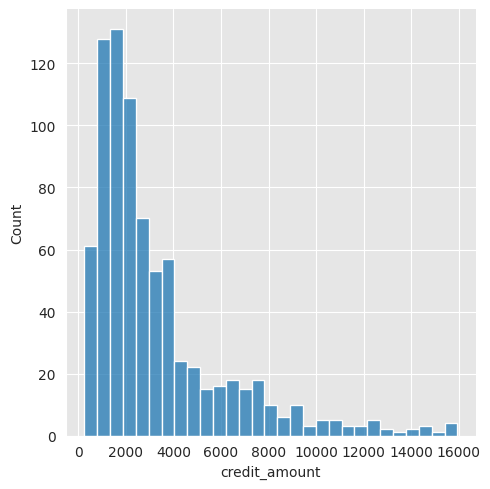

In [13]:
sns.displot(training_data["credit_amount"])

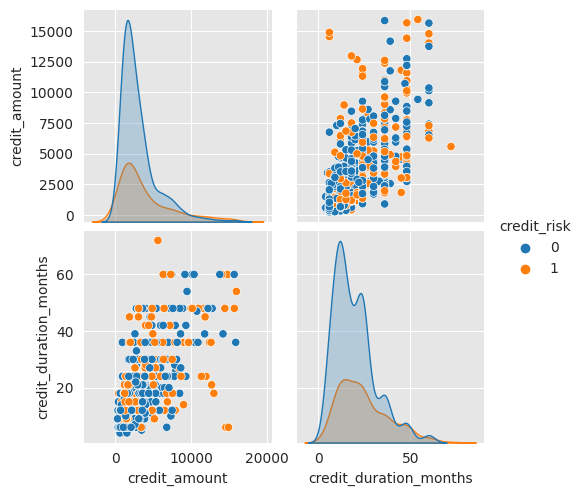

In [15]:
new_df = training_data[["credit_amount", "credit_duration_months", "credit_risk"]]
sns.pairplot(new_df, hue="credit_risk")

<Axes: >

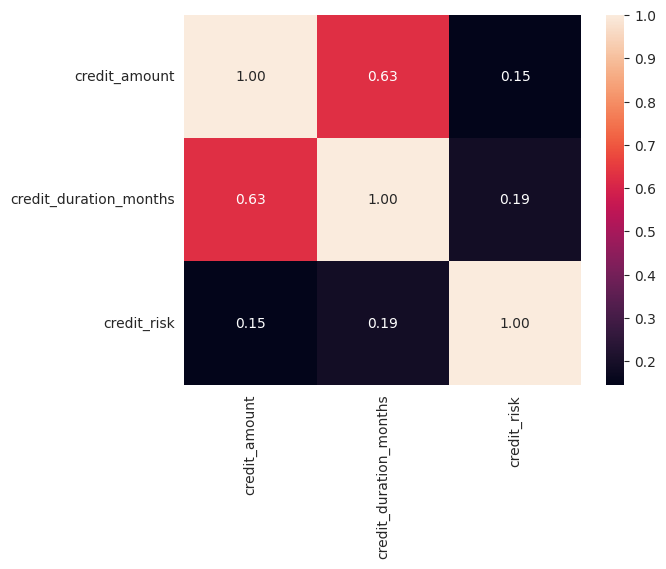

In [16]:
correlation_matrix = new_df.corr()
sns.heatmap(correlation_matrix, annot=True,fmt=".2f")

### 2.2 <a name="22">Select features to build the model</a> 
(<a href="#2">Go to Data Processing</a>)

Let's use all the features. Below you see a snippet of code that separates categorical and numerical columns based on their data type. This should only be used if we are sure that the data types are correctly assigned (check during EDA). Mindful with some of the feature names - they suggest numerical values but upon inspection it should become clear that they are actually categoricals (e.g. `employed_since_years` has been binned into groups).


In [17]:
# Grab model features/inputs and target/output
categorical_features = (
    training_data.drop("credit_risk", axis=1)
    .select_dtypes(include="object")
    .columns.tolist()
)
print("Categorical columns:", categorical_features)

print("")

numerical_features = (
    training_data.drop("credit_risk", axis=1)
    .select_dtypes(include=np.number)
    .columns.tolist()
)
print("Numerical columns:", numerical_features)

Categorical columns: ['sex', 'personal_status', 'checking_account_status', 'credit_history', 'credit_purpose', 'savings', 'employed_since_years', 'installment_rate', 'other_debtors_guarantors', 'present_residence_since', 'property', 'other_installment_plans', 'housing', 'num_existing_credits', 'job_status', 'num_people_liable_for']

Numerical columns: ['ID', 'credit_duration_months', 'credit_amount', 'age_years', 'age_groups']


We notice that `ID` is identified as numerical column. ID's should never be used as features for training as they are unique by row. Let's drop the ID from the model features after we have separated target and features. Also make sure to remove the sensitive feature so it does not end up as input for training.

In [18]:
sensitive_feature = "age_groups"

try:
    numerical_features.remove(sensitive_feature)
except:
    pass

try:
    categorical_features.remove(sensitive_feature)
except:
    pass

model_target = "credit_risk"
model_features = categorical_features + numerical_features

print("Model features: ", model_features)
print("\n")
print("Model target: ", model_target)

Model features:  ['sex', 'personal_status', 'checking_account_status', 'credit_history', 'credit_purpose', 'savings', 'employed_since_years', 'installment_rate', 'other_debtors_guarantors', 'present_residence_since', 'property', 'other_installment_plans', 'housing', 'num_existing_credits', 'job_status', 'num_people_liable_for', 'ID', 'credit_duration_months', 'credit_amount', 'age_years']


Model target:  credit_risk


In [19]:
to_remove = "ID"

# Drop 'ID' feature from the respective list(s)
if to_remove in model_features:
    model_features.remove(to_remove)
if to_remove in categorical_features:
    categorical_features.remove(to_remove)
if to_remove in numerical_features:
    numerical_features.remove(to_remove)

Let's also remove `age_years` as this is an obvious proxy for the age groups.

In [20]:
to_remove = "age_years"

# Drop 'ID' feature from the respective list(s)
if to_remove in model_features:
    model_features.remove(to_remove)
if to_remove in categorical_features:
    categorical_features.remove(to_remove)
if to_remove in numerical_features:
    numerical_features.remove(to_remove)

### 2.3 <a name="23">Feature transformation</a>
(<a href="#2">Go to Data Processing</a>)

Here, you have different options. You can use Reweighing, Disparate Impact Remover or Suppression. However, in this notebook you should try to implement Equalized Odds postprocessing. Therefore, no transformation is required at this point.

### 2.4 <a name="24">Train - Validation Datasets</a>
(<a href="#2">Go to Data Processing</a>)

We already have training and test datasets, but no validation dataset (which you need to create). Furthermore, the test dataset is missing the labels - the goal of the project is to predict these labels. 

To produce a validation set to evaluate model performance, split the training dataset into train and validation subsets using sklearn's [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function. 

In [21]:
train_data, val_data = train_test_split(
    training_data, test_size=0.1, shuffle=True, random_state=23
)

# Print the shapes of the Train - Test Datasets
print(
    "Train - Test - Validation datasets shapes: ",
    train_data.shape,
    test_data.shape,
    val_data.shape,
)

train_data.reset_index(inplace=True, drop=True)
val_data.reset_index(inplace=True, drop=True)

Train - Test - Validation datasets shapes:  (720, 24) (200, 23) (80, 24)


### 2.5 <a name="25">Data processing with Pipeline</a>
(<a href="#2">Go to Data Processing</a>)

Build a [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)  to impute the missing values and scale the numerical features, and finally train a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)  on the imputed and scaled dataset. 


In [22]:

numerical_processor = Pipeline(
    [("num_imputer", SimpleImputer(strategy="mean")), ("num_scaler", MinMaxScaler())]
)

categorical_processor = Pipeline(
    [
        ("cat_imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("cat_encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)


data_processor = ColumnTransformer(
    [
        ("numerical_processing", numerical_processor, numerical_features),
        ("categorical_processing", categorical_processor, categorical_features),
    ]
)



pipeline = Pipeline(
    [
        ("data_processing", data_processor),
        ("lg", LogisticRegression(random_state=0)),
    ]
)


from sklearn import set_config

set_config(display="diagram")
pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('numerical_processing',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['credit_duration_months',
                                                   'credit_amount']),
                                                 ('categorical_processing',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('cat_encoder',
                                                                   OneHot...))]),
                                                  ['sex', 'personal_status',
                                                   'checking_account_status',
                                                   'credit_history',
                                                   'credit_purpose', 'savings',
                                                   'employed_since_years',
                                                   'installment_rate',
                                                   'other_debtors_guarantors',
                                                   'present_residence_since',
                                                   'property',
                                                   'other_installment_plans',
                                                   'housing',
                                                   'num_existing_credits',
                                                   'job_status',
                                                   'num_people_liable_for'])])),
                ('lg', LogisticRegression(random_state=0))])

## 3. <a name="3">Train (and Tune) a Classifier</a> (Implement)
(<a href="#0">Go to top</a>)

Train (and tune) the [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) pipeline. For tuning, you can try different imputation strategies, different scaling methods.

In [23]:
X_train = train_data[model_features]
y_train = train_data[model_target]

data_processor.fit(X_train)

ft_names = numerical_features + list(
    data_processor.transformers_[1][1]
    .named_steps["cat_encoder"]
    .get_feature_names(categorical_features)
)


X_train_prep = pd.DataFrame(
    data_processor.transform(X_train).todense(), columns=ft_names
)


eo_model = ThresholdOptimizer(
    estimator=pipeline[-1],
    constraints="equalized_odds",
    objective="accuracy_score",
    grid_size=1000,
    flip=False,
    prefit=False,
    predict_method="deprecated",
)


eo_model.fit(X_train_prep, y_train, sensitive_features=train_data["age_groups"].values)

ThresholdOptimizer(constraints='equalized_odds',
                   estimator=LogisticRegression(random_state=0))

## 4. <a name="4">Make Predictions on the Test Dataset</a> (Implement)
(<a href="#0">Go to top</a>)

Use the trained classifier to predict the labels on the test set. Below you will find a code snippet that evaluates for DI.

In [29]:
# Implement here

# Get test data to test the classifier
# ! test data should come from german_credit_test.csv !

# Use the trained model to make predictions on the test dataset
test_predictions = eo_model.predict(
    data_processor.transform(test_data[model_features]).todense(),
    sensitive_features=test_data["age_groups"].values,
)

## 5. <a name="5">Write the test predictions to a CSV file</a> (Given)
(<a href="#0">Go to top</a>)

Use the following code to write the test predictions to a CSV file. Download locally the CSV file from the SageMaker instance, and upload it to the [__MLU leaderboard__](https://mlu.corp.amazon.com/contests/redirect/93).

In [34]:
result_df = pd.DataFrame(columns=["ID", "credit_risk"])
result_df["ID"] = test_data["ID"].tolist()
result_df["credit_risk"] = test_predictions

result_df.to_csv("../../data/final_project/project_day3_result.csv", index=False)

In [35]:
print("Double-check submission file against the sample_submission.csv")
sample_submission_df = pd.read_csv("../../data/final_project/sample_submission.csv")
print(
    "Differences between project_day3_result IDs and sample submission IDs:",
    (sample_submission_df["ID"] != result_df["ID"]).sum(),
)

Double-check submission file against the sample_submission.csv
Differences between project_day3_result IDs and sample submission IDs: 0


This is the end of the notebook.